In [1]:
from pathlib import Path
import os
code_dir = Path().cwd().parent
os.chdir(code_dir)

In [28]:
import functions as funcs
import matplotlib.pyplot as plt
import cv2
import numpy as np
import shutil
import random
from ultralytics import YOLO
import pickle

In [3]:
image_dir = Path() /'D:'/'singh'/'Documents'/'zoo'

In [4]:
if not (image_dir/'Good_Bad').is_dir():
    good_bad_dir = image_dir/'Good_Bad'
    good_bad_dir.mkdir(parents=True, exist_ok=True)
else:
    good_bad_dir = image_dir/'Good_Bad'

In [ ]:
# Hot many images are there?
bad_counter = 0
for file in (good_bad_dir/'Low_Quality').iterdir():
    if (file.is_file()) & (file.suffix in ['.jpeg', '.jpg']):
        img = funcs.get_image_from_path(file_path=file)
        if img.shape == (1000,1000,3):
            bad_counter+=1 
print(f"{bad_counter=}")

In [47]:
good_temp_folder = image_dir/'temp_image_folder_good'
good_temp_folder.mkdir(parents=True, exist_ok=True)

In [7]:
ai_training_dir = Path().cwd().parent / r"AI Training Sets-20231024T092556Z-001"/r"AI Training Sets"
ai_training_dir

WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/AI Training Sets-20231024T092556Z-001/AI Training Sets')

In [43]:
good_image_folders = ["Set4-1_WBC_Images", 
                      "Set5-1_WBC_Images", 
                      r"Goldilocks-Test_Images/Good", 
                      r"Goldilocks-Test_Images/Dense", 
                      r"Goldilocks-Test_Images/Sparse", 
                      "No_WBCs_Images"]

In [48]:
file_counter = 0
for folder in good_image_folders:
    for file in (ai_training_dir/folder).iterdir():
         if (file.is_file()) & (file.suffix in ['.jpeg', '.jpg']):
            img = funcs.get_image_from_path(file_path=file)
            if img.shape == (1000,1000,3):
                assert good_temp_folder.exists(), "Folder not found"
                shutil.copy(src=file, dst=good_temp_folder)
                file_counter += 1
                print(f"file_counter:{file_counter:03d}", end='\r')

In [19]:
def rotate_image_thrice(image:np.ndarray) -> tuple[np.ndarray]:
    """ Takes an image and rotates it three times clockwise 
        and returns rotated images """
    rot_90 = cv2.rotate(src=image,rotateCode=cv2.ROTATE_90_CLOCKWISE)
    rot_180 = cv2.rotate(src=rot_90,rotateCode=cv2.ROTATE_90_CLOCKWISE)
    rot_270 = cv2.rotate(src=rot_180,rotateCode=cv2.ROTATE_90_CLOCKWISE)
    return rot_90, rot_180, rot_270

In [49]:
good_temp_files = [file for file in good_temp_folder.iterdir() if (file.is_file())  & (file.suffix in ['.jpeg', '.jpg'])]
len(good_temp_files)

2029

In [58]:
(2400-len(good_temp_files)) - 3*124

-1

In [84]:
# Saving additional augmented 124 files to balance the dataset 
for file in good_temp_files[:124]:
    file_name = file.parts[-1].split(".")[0]
    img = funcs.get_image_from_path(file_path=file)
    rot90, rot180, rot270 = rotate_image_thrice(image=img)
    for img, img_name in zip([rot90, rot180, rot270],
                             [f"{file_name}_90.jpg", f"{file_name}_180.jpg", f"{file_name}_270.jpg"]):
        funcs.save_image_to_path(image=img, file_path=good_temp_folder/img_name)        

In [87]:
good_temp_files = [file for file in good_temp_folder.iterdir() if (file.is_file())  & (file.suffix in ['.jpeg', '.jpg'])]
len(good_temp_files)

2401

In [89]:
random.shuffle(good_temp_files)

In [91]:
split_index = int(0.80 * len(good_temp_files))
good_train_files = good_temp_files[:split_index]
good_val_files = good_temp_files[split_index:]

In [97]:
train_dir = image_dir/"good_bad_dataset"/'train'
val_dir = image_dir/"good_bad_dataset"/'val'
for file in good_train_files:
    dest = train_dir/'good'
    if dest.is_dir():    
        shutil.copy(src=file, dst=dest)
        
for file in good_val_files:
    dest = val_dir/'good'
    if dest.is_dir():    
        shutil.copy(src=file, dst=dest)

In [98]:
sum([1 for file in (train_dir/'good').iterdir() if file.is_file()]), sum([1 for file in (val_dir/'good').iterdir() if file.is_file()])

(1920, 481)

In [17]:
bad_counter*4

2400

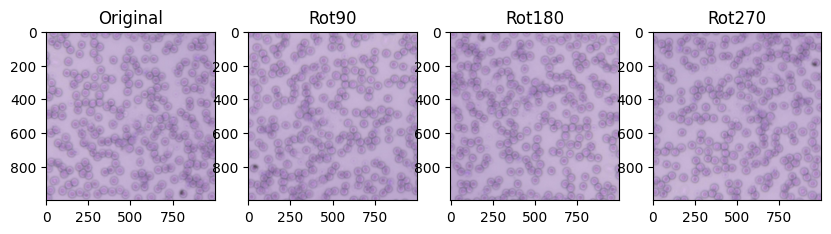

In [20]:
test_file = good_bad_dir/'Low_Quality'/"B087_3M2_T19004_RT_x40_z0_i42j30.jpg"

img = funcs.get_image_from_path(file_path=test_file)
rot_90, rot_180, rot_270 = rotate_image_thrice(image=img)

_, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,6))
ax[0].imshow(img)
ax[0].set_title('Original')
ax[1].imshow(rot_90)
ax[1].set_title('Rot90')
ax[2].imshow(rot_180)
ax[2].set_title('Rot180')
ax[3].imshow(rot_270)
ax[3].set_title('Rot270')
plt.show()

In [21]:
def make_classification_folders(folder_path:Path=None, 
                                dir_name:str="good_bad_dataset", 
                                classes:list[str]=['good', 'bad']) -> None:
    """ Makes a directory structure for the Yolo image classification training 
    """
    if folder_path is None:
        folder_path = Path.cwd()
    
    if (folder_path/dir_name).is_dir():
        print("Folder exists - not creating new ones")
        return

    root_folder = folder_path/dir_name
    subfolders = ['train', 'val']
    for subfolder in subfolders:
        train_val_folders = root_folder/subfolder
        for cls in classes:
            class_folder = train_val_folders/cls
            
            train_val_folders.mkdir(parents=True, exist_ok=True)
            class_folder.mkdir(parents=True, exist_ok=True)

In [22]:
make_classification_folders(folder_path=image_dir)

Folder exists - not creating new ones


In [23]:
# split train-val -> 80-20
2400 * 0.80, 2400 * 0.20 

(1920.0, 480.0)

In [25]:
temp_folder = image_dir/'temp_image_folder'
temp_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
if not any((temp_folder).iterdir()):
    for file in (good_bad_dir/'Low_Quality').iterdir():
        if (file.is_file()) & (file.suffix in ['.jpeg', '.jpg']):
            file_name = file.parts[-1].split(".")[0]
            img = funcs.get_image_from_path(file_path=file)
            rot90, rot180, rot270 = rotate_image_thrice(image=img)
            for img, img_name in zip([img, rot90, rot180, rot270], 
                                    [f"{file_name}.jpg", f"{file_name}_90.jpg", f"{file_name}_180.jpg", f"{file_name}_270.jpg"]):
                funcs.save_image_to_path(image=img, file_path=temp_folder/img_name)
else:
    print("Temp folder has files in it")

In [129]:

temp_files = [file for file in temp_folder.iterdir() if (file.is_file()) & (file.suffix == '.jpg')]
random.shuffle(temp_files)

In [140]:
split_index = int(0.80 * len(temp_files))
train_files = temp_files[:split_index]
val_files = temp_files[split_index:]

In [157]:
train_dir = image_dir/"good_bad_dataset"/'train'
val_dir = image_dir/"good_bad_dataset"/'val'
for file in val_files:
    shutil.copy(src=file, dst=val_dir/'bad')

In [ ]:
print(sum([1 for file in (val_dir/'bad').iterdir() if (file.is_file()) & (file.suffix == '.jpg')]))
print(sum([1 for file in (train_dir/'bad').iterdir() if (file.is_file()) & (file.suffix == '.jpg')]))

In [27]:
# Delete the temp folder
shutil.rmtree(temp_folder)

In [17]:
good_bad_model = YOLO(model=code_dir/'Good_Bad'/"good_bad_weights_16Dec23.pt")

In [8]:
aug_img_files = [file for file in (ai_training_dir/"Augmentated_Images").iterdir() if file.is_file()]
aug_img_files

[WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/AI Training Sets-20231024T092556Z-001/AI Training Sets/Augmentated_Images/71046046_r0.jpg'),
 WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/AI Training Sets-20231024T092556Z-001/AI Training Sets/Augmentated_Images/71046046_r1.jpg'),
 WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/AI Training Sets-20231024T092556Z-001/AI Training Sets/Augmentated_Images/71046046_r2.jpg'),
 WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/AI Training Sets-20231024T092556Z-001/AI Training Sets/Augmentated_Images/71047283_r0.jpg'),
 WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/AI Training Sets-20231024T092556Z-001/AI Training Sets/Augmentated_Images/71047283_r1.jpg'),
 WindowsPath('c:/Users/singh/OneDrive/MSc_in_AI/Python/Zooinverse/AI Training Sets-20231024T092556Z-001/AI Training Sets/Augmentated_Images/71047283_r2.jpg'),
 WindowsPath('c:/Users/singh/OneDrive/MSc_in_A

In [133]:
results = good_bad_model.predict(aug_img_files[0])


image 1/1 c:\Users\singh\OneDrive\MSc_in_AI\Python\Zooinverse\AI Training Sets-20231024T092556Z-001\AI Training Sets\Augmentated_Images\71046046_r0.jpg: 1024x1024 good 1.00, bad 0.00, 443.8ms
Speed: 41.9ms preprocess, 443.8ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 1024)


In [ ]:
aug_img_classify = [result[0].names[np.argmax(result[0].probs.data.numpy())] for result in [good_bad_model.predict(file) for file in aug_img_files]]
aug_img_classify

In [22]:
low_qual_files = [] 
for file in list((good_bad_dir/"Low_Quality").iterdir())[:20]:
    if file.is_file():
        img = funcs.get_image_from_path(file_path=file)
        img = cv2.rotate(src=img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        low_qual_files.append(img)

In [ ]:
low_qual_classify = [result[0].names[np.argmax(result[0].probs.data.numpy())] for result in [good_bad_model.predict(file) for file in low_qual_files]]

In [24]:
low_qual_score = sum([1 for pred in low_qual_classify if pred=="bad"])/len(low_qual_classify)
low_qual_score

0.75

## Apply model on patches

In [26]:
if (code_dir/'Good_Bad'/'patch_class_results.pickle').exists():
    with open(file=code_dir/'Good_Bad'/'patch_class_results.pickle', mode='rb') as f:
        patch_file_names = pickle.load(file=f)
else:         
    patch_file_names = [file for file in (image_dir/r"[B001]0J4_T19085_RT").iterdir() if (file.is_file()) & (file.suffix in['.jpeg', '.jpg'])]

In [ ]:
patch_classify_result = [result[0].names[np.argmax(result[0].probs.data.numpy())] for result in [good_bad_model.predict(file) for file in patch_file_names]]

In [49]:
with open(file=code_dir/'Good_Bad'/'patch_class_results.pickle', mode='wb') as f:
        pickle.dump(obj=patch_classify_result, file=f)

In [37]:
good_patch_indices = [i for i, result in enumerate(patch_classify_result) if result=='good']
bad_patch_indices = [i for i, result in enumerate(patch_classify_result) if result=='bad']

In [38]:
len(good_patch_indices), len(patch_classify_result), len(bad_patch_indices)

(1814, 1849, 35)

In [45]:
good_images = [funcs.get_image_from_path(file_path=patch_file_names[idx]) for idx in good_patch_indices[4:8]]
bad_images = [funcs.get_image_from_path(file_path=patch_file_names[idx]) for idx in bad_patch_indices[4:8]]

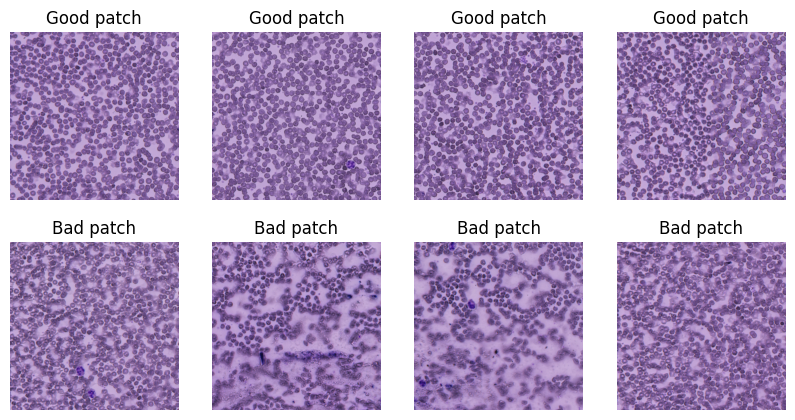

In [48]:
_, ax = plt.subplots(nrows=2, ncols=len(good_images), figsize=(10,5))
for col, good_img in enumerate(good_images):
    ax[0,col].imshow(good_img)
    ax[0,col].set_title("Good patch")
    ax[0,col].axis('off')
for col, bad_img in enumerate(bad_images):
    ax[1,col].imshow(bad_img)
    ax[1,col].set_title("Bad patch")
    ax[1,col].axis('off')
plt.show()

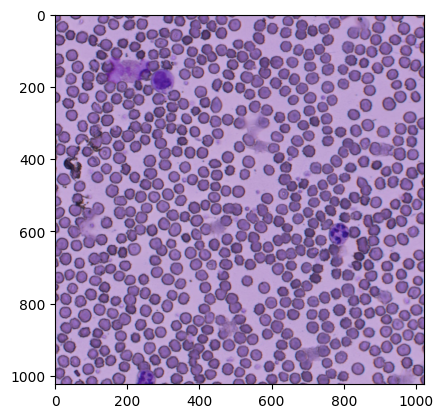

In [70]:
test_img_path = patch_file_names[good_patch_indices[31]]
test_img = funcs.get_image_from_path(file_path=test_img_path)
plt.imshow(test_img)
plt.show()

In [74]:
yolo_model = YOLO(model=Path().cwd().parent /'Yolo'/"best.pt")

In [76]:
test_img_path1 = patch_file_names[good_patch_indices[0]]
test_img_path1

WindowsPath('D:singh/Documents/zoo/[B001]0J4_T19085_RT/[B001]0J4_T19085_RT_0_0.jpg')

In [ ]:
test_result1 = yolo_model.predict(source=test_img_path1)
# If there are not detections
test_result1[0].boxes.data.numpy().size == 0

In [86]:
test_results = yolo_model.predict(source=test_img_path)


image 1/1 D:singh\Documents\zoo\[B001]0J4_T19085_RT\[B001]0J4_T19085_RT_0_38.jpg: 1024x1024 2 Neutrophils, 1 Monocyte, 5299.6ms
Speed: 13.0ms preprocess, 5299.6ms inference, 37.9ms postprocess per image at shape (1, 3, 1024, 1024)


In [95]:
test_results[0].names, test_results[0].path.split("\\")[-1].split(".")[0]

({0: 'Neutrophil',
  1: 'Lymphocyte',
  2: 'Monocyte',
  3: 'Eosinophil',
  4: 'Basophil'},
 '[B001]0J4_T19085_RT_0_38')

In [101]:
boxes = test_results[0].boxes.xywh.numpy().astype(np.int32)
boxes

array([[ 785,  607,   71,   71],
       [ 297,  182,   71,   70],
       [ 251, 1001,   69,   45]])

In [114]:
def get_roi(image: np.ndarray, 
            xy: tuple[int, int] | np.ndarray, 
            offset: tuple[int, int] = (70, 70)) -> np.ndarray:
    """ Given an image and xy coordinates, returns the ROI from the image using the offset """
    img_height, img_width, _ = image.shape
    x, y = xy

    # Ensure the ROI does not exceed image dimensions
    x = max(0, min(x, img_width - 1))
    y = max(0, min(y, img_height - 1))

    # Calculate ROI boundaries using the offset
    roi_x1 = max(0, x - offset[0])
    roi_y1 = max(0, y - offset[1])
    roi_x2 = min(img_width, x + offset[0])
    roi_y2 = min(img_height, y + offset[1])

    # Extract the ROI using NumPy array slicing
    roi = image[roi_y1:roi_y2, roi_x1:roi_x2, :]

    return roi

In [125]:
roi = get_roi(image=test_results[0].orig_img[...,::-1], xy=boxes[1][:2])

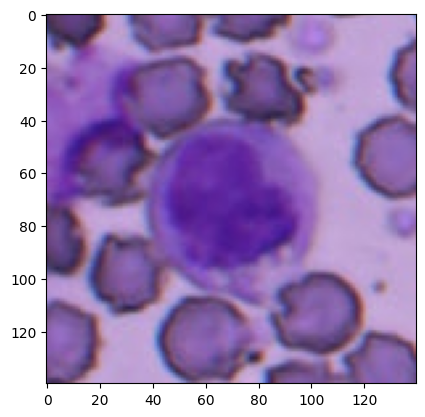

In [126]:
plt.imshow(roi)
plt.show()

In [ ]:
boxes = test_results[0].boxes.xywh.numpy().astype(np.int32)


In [137]:
for i, box in enumerate(boxes):
    xy = box[:2]
    roi = get_roi(image=test_results[0].orig_img[..., ::-1], xy=xy)
    box_name = f"{i:02d}"
    file_name = test_results[0].path.split("\\")[-1].split(".")[0]
    print(f"{file_name}_B{box_name}")

[B001]0J4_T19085_RT_0_38_B00
[B001]0J4_T19085_RT_0_38_B01
[B001]0J4_T19085_RT_0_38_B02


In [143]:
set([test_results[0].names[pred_class] for pred_class in test_results[0].boxes.cls.numpy().astype(np.uint)])

{'Monocyte', 'Neutrophil'}

In [134]:
rl = ['[B001]0J4_T19085_RT_0_38_00', '[B001]0J4_T19085_RT_0_38_01', '[B001]0J4_T19085_RT_0_38_02']
[r[:-3] for r in rl] 

['[B001]0J4_T19085_RT_0_38',
 '[B001]0J4_T19085_RT_0_38',
 '[B001]0J4_T19085_RT_0_38']

In [144]:
for cell_name in set([test_results[0].names[pred_class] for pred_class in test_results[0].boxes.cls.numpy().astype(np.uint)]):
    folder= Path().cwd()/"Good_Bad"/cell_name
    folder.mkdir(parents=True, exist_ok=True)

array([[[137, 100, 169],
        [141, 101, 171],
        [143, 101, 175],
        ...,
        [128,  91, 122],
        [123,  81, 103],
        [116,  72,  89]],

       [[140, 103, 173],
        [141, 104, 174],
        [143, 103, 176],
        ...,
        [122,  83, 114],
        [113,  70,  97],
        [103,  61,  83]],

       [[142, 106, 178],
        [141, 105, 179],
        [141, 103, 178],
        ...,
        [115,  71, 104],
        [ 99,  59,  94],
        [ 88,  51,  85]],

       ...,

       [[193, 164, 218],
        [193, 164, 218],
        [193, 164, 218],
        ...,
        [119,  92, 147],
        [124,  91, 146],
        [126,  91, 145]],

       [[195, 165, 215],
        [195, 165, 215],
        [194, 166, 217],
        ...,
        [113,  89, 149],
        [121,  90, 147],
        [126,  93, 148]],

       [[195, 166, 214],
        [196, 167, 215],
        [195, 167, 218],
        ...,
        [110,  86, 148],
        [119,  90, 148],
        [127,  94, 151]]

In [142]:
from ultralytics.engine.results import Results

In [165]:
def save_rois(result:Results, folder_path:Path) -> None:
    """Takes a YOLO result object, extracts the ROI boxes 
        and saves them in corresponding folders
    """
    assert isinstance(folder_path, Path), "folder_path needs to be a Path object"
    # No detections
    if result[0].boxes.data.numpy().size == 0:
        return 
    # For detections
    image_name = result[0].path.split("\\")[-1].split(".")[0]
    names_dict = result[0].names
    boxes = result[0].boxes.xywh.numpy().astype(np.int32)
    classification = [names_dict[cls] for cls in result[0].boxes.cls.numpy().astype(np.uint)]
    for i, (box, cls) in enumerate(zip(boxes, classification)):
        xy = box[:2]
        roi = get_roi(image=result[0].orig_img[..., ::-1], xy=xy)
        box_name = f"B{i:02d}"
        file_name = f"{image_name}_{box_name}.jpg"
        assert (folder_path/cls).exists(), "Folder not found"
        funcs.save_image_to_path(image = roi, file_path=folder_path/cls/file_name)

In [166]:
save_rois(result=test_results, folder_path=Path().cwd()/"Good_Bad")

In [200]:
def find_roi_in_image(image:np.ndarray, roi:np.ndarray) -> tuple:
# Find the location of a ROI in an image
    whole_gray = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(src=roi, code=cv2.COLOR_BGR2GRAY)
    result = cv2.matchTemplate(whole_gray, template_gray, cv2.TM_CCOEFF_NORMED)
    _, _, _, top_left = cv2.minMaxLoc(result)
    roi_h, roi_w = template_gray.shape
    center_xy:tuple = top_left[0]+roi_w//2, top_left[1]+roi_h//2
    # bottom_right = (top_left[0] + w, top_left[1] + h)
    print(f"{center_xy=}")

In [206]:
test_roi = funcs.get_image_from_path(file_path=r"Good_Bad\Neutrophil\[B001]0J4_T19085_RT_0_38_B02.jpg")

In [207]:
find_roi_in_image(image=test_results[0].orig_img[...,::-1], roi=test_roi)

center_xy=(251, 977)


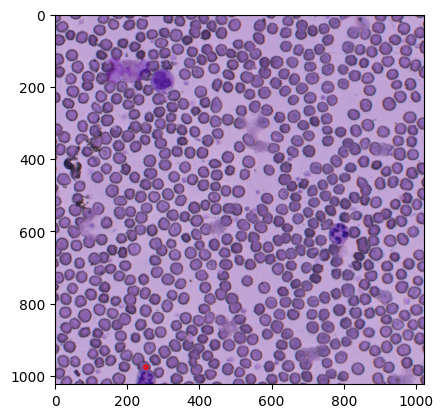

In [208]:
test_im = test_results[0].orig_img[...,::-1].astype(np.int32)
test_im2 = cv2.circle(img=test_im, center=(251, 977), radius=5, color=(255,0,0), thickness=3)
plt.imshow(test_im2)
plt.show() 

